## Load/import packages

In [1]:
import json
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import kerastuner as kt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils import class_weight

from functions import f1, plot_history, arr_replacevalue
from load_features import (
    train_features,
    val_features,
    test_features,
    train_labels,
    val_labels,
    labels_reshaper,
    features_reshaper,
)


from os import listdir
from os.path import splitext
from os.path import join

%matplotlib inline

# Limit GPU memory usage
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Prepare data

## Reshape feautures, labels
The model gets more unstable and validation scores converge later with higher sequence length. Increasing sequence length does not improve the models performance.

In [11]:
# Reshape data to specified sequence length
length = 60
seq_train_features = features_reshaper(train_features, length)
seq_val_features = features_reshaper(val_features, length)
# seq_test_features = features_reshaper(test_features, length)

seq_train_labels = labels_reshaper(train_labels, length)
seq_val_labels = labels_reshaper(val_labels, length)

## Compute sample weights

In [12]:
# Convert one-hot encoded labels back to label integers
train_label_ints = np.argmax(seq_train_labels, axis=2)

# Compute class weights with sklearn
class_weights = class_weight.compute_class_weight(
    "balanced", np.unique(train_label_ints), train_label_ints.flatten()
)
d_class_weights = dict(enumerate(class_weights))

# Copy label integer array
arr = train_label_ints.copy()

# Pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample
train_samples_weights = arr_replacevalue(arr, d_class_weights)

# Build HP tuner model

In [45]:
def build_model(hp):
    hp_unit_layer1 = hp.Int("units", min_value=256, max_value=2048, step=256)
    hp_unit_layer2 = hp.Int("units", min_value=256, max_value=2048, step=256)
    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    model.add(layers.LSTM(hp_unit_layer1, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(hp_unit_layer2, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model

## Hyperparameter tuning

In [ ]:
# Keras-tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=64,
    executions_per_trial=5,
    seed=1337,
    project_name="Tuner_search",
    overwrite=True,
)

# Check the defined hyperparameter search space
tuner.search_space_summary()

# Set early stoppping 
es = tf.keras.callbacks.EarlyStopping(monitor="val_f1", verbose=1, patience=3, restore_best_weights=True)

# Do random serach for optimal hyperparameters
tuner.search(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    epochs=100,
    validation_data=(seq_val_features, seq_val_labels),
    callbacks=[es],
    verbose=2,
)

Epoch 1/100
481/481 - 30s - loss: 1.3902 - accuracy: 0.4851 - f1: 0.2313 - auc: 0.8413 - val_loss: 1.7636 - val_accuracy: 0.3320 - val_f1: 0.0495 - val_auc: 0.7292
Epoch 2/100
481/481 - 27s - loss: 0.9844 - accuracy: 0.6768 - f1: 0.5195 - auc: 0.9334 - val_loss: 1.6137 - val_accuracy: 0.4372 - val_f1: 0.2353 - val_auc: 0.7961
Epoch 3/100
481/481 - 28s - loss: 0.8311 - accuracy: 0.7471 - f1: 0.6597 - auc: 0.9581 - val_loss: 1.6468 - val_accuracy: 0.4223 - val_f1: 0.2423 - val_auc: 0.7837
Epoch 4/100
481/481 - 28s - loss: 0.7418 - accuracy: 0.7929 - f1: 0.7353 - auc: 0.9716 - val_loss: 1.6002 - val_accuracy: 0.4538 - val_f1: 0.3051 - val_auc: 0.8064
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Epoch 1/100
481/481 - 30s - loss: 1.3835 - accuracy: 0.4848 - f1: 0.2267 - auc: 0.8425 - val_loss: 1.7182 - val_accuracy: 0.3692 - val_f1: 0.0920 - val_auc: 0.7499
Epoch 2/100
481/481 - 27s - loss: 0.9894 - accuracy: 0.6707 - f1: 0.5149 - auc: 0.9313 - val_los

Epoch 1/100
481/481 - 42s - loss: 1.3584 - accuracy: 0.4993 - f1: 0.2708 - auc: 0.8514 - val_loss: 1.6926 - val_accuracy: 0.3777 - val_f1: 0.1586 - val_auc: 0.7587
Epoch 2/100
481/481 - 41s - loss: 0.9374 - accuracy: 0.6984 - f1: 0.5680 - auc: 0.9413 - val_loss: 1.6584 - val_accuracy: 0.4090 - val_f1: 0.2161 - val_auc: 0.7801
Epoch 3/100
481/481 - 39s - loss: 0.7857 - accuracy: 0.7707 - f1: 0.6973 - auc: 0.9648 - val_loss: 1.6192 - val_accuracy: 0.4339 - val_f1: 0.2776 - val_auc: 0.7984
Epoch 4/100
481/481 - 39s - loss: 0.7025 - accuracy: 0.8165 - f1: 0.7680 - auc: 0.9769 - val_loss: 1.6503 - val_accuracy: 0.4220 - val_f1: 0.2918 - val_auc: 0.7953
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Epoch 1/100
481/481 - 41s - loss: 1.3504 - accuracy: 0.5094 - f1: 0.2805 - auc: 0.8558 - val_loss: 1.7148 - val_accuracy: 0.3696 - val_f1: 0.0805 - val_auc: 0.7510
Epoch 2/100
481/481 - 38s - loss: 0.9411 - accuracy: 0.7049 - f1: 0.5737 - auc: 0.9422 - val_los

# Build optimal HP model

In [ ]:
tuner.results_summary()

In [ ]:
## Grab optimal hyperparameter
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

## Define optimal model

In [29]:
def build_opt_model():
    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    # Increasing the units to 512, decreases the loss and it improves accuracy, f1 etc. 
    # Increasing it beyond 512 units doesn't have much of effect.
    model.add(layers.LSTM(2048, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model


# Other ok models:
# 1024 units (layer 1) + 512 units (layer 2) (Sequence length: 120)
# 2048 units (layer 1) + 1024 units (layer 2) + label_smoothing=0.1 (Sequence length: 60)

# Train + Evaluate model

## Best model results

In [ ]:
cnn_rnn_LSTM = build_opt_model()
cnn_rnn_LSTM.summary()

history_best = cnn_rnn_LSTM.fit(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    validation_data=(seq_val_features, seq_val_labels),
    epochs=50,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor="val_f1", verbose=1, patience=6, restore_best_weights=False
#         )
#     ],
    verbose=2,
)

In [ ]:
results = cnn_rnn_LSTM.evaluate(seq_val_features, seq_val_labels, verbose=0)
print(dict(zip(cnn_rnn_LSTM.metrics_names, results)))

## Plot performance of model

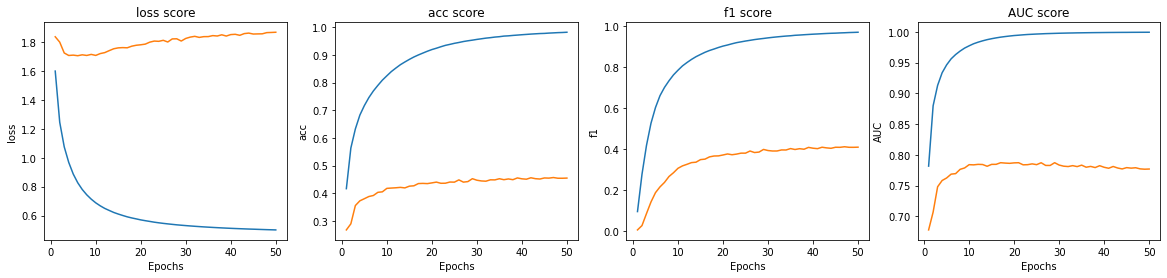

In [27]:
model_hist = history_best.history

labels = [*model_hist.keys()]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
epochs = range(1, len(model_hist["loss"]) + 1)
for data, label in zip(
    [model_hist["loss"], model_hist["val_loss"]], [labels[0], labels[4]]
):
    axes[0].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["accuracy"], model_hist["val_accuracy"]], [labels[1], labels[5]]
):
    axes[1].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["f1"], model_hist["val_f1"]], [labels[2], labels[6]]
):
    axes[2].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["auc"], model_hist["val_auc"]], [labels[3], labels[7]]
):
    axes[3].plot(epochs, data, label=label)

for i, label in zip(range(4), ["loss", "acc", "f1", "AUC"]):
    axes[i].set_title(label + " score")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(label)

In [28]:
# Save model performance to json file
with open('data/LSTM_modelperformance_256_128.json', 'w') as fp:
    json.dump(model_hist, fp)

## Calculate precision score with SKlearn

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

In [ ]:
# Do predictions on test set
val_predv2 = v2.predict(seq_val_features, verbose=0)

# Reshape back to (frame, label)
val_predv2 = np.reshape(
    val_predv2, (val_predv2.shape[0] * val_predv2.shape[1], val_predv2.shape[2])
)

# Convert one hot encoding to integers
val_predv2 = np.argmax(val_predv2, axis=1)

In [ ]:
# Reshape back to (frame, label)
val_true = np.reshape(
    seq_val_labels, (seq_val_labels.shape[0] * seq_val_labels.shape[1], seq_val_labels.shape[2])
)
val_true = np.argmax(val_true, axis=1)

In [ ]:
# F1 Results with model v3
for avg in [None,  'micro', 'macro', 'weighted']:
    score = f1_score(val_true, val_predv3, average=avg)
    print(f'Average method: {avg}, f1-score: {score}' )

## Plot the model architecture

In [ ]:
# Plot CNN-LSTM model
tf.keras.utils.plot_model(
    cnn_rnn_LSTM,
    to_file="images/best_CNN-LSTM_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Save model+weights to folder

In [ ]:
# Save model
tf.keras.Model.save(cnn_rnn_LSTM, filepath="data/CNN-LSTM_model.h5")

# Predict on test set

In [ ]:
# Load best CNN-LSTM model
best_LSTM = tf.keras.models.load_model(
    filepath="data/CNN-LSTM_model.h5", custom_objects={"F1-metric": f1}, compile=False
)

In [ ]:
# Do predictions on test set
test_pred = best_LSTM.predict(seq_test_features, verbose=0)

# Reshape back to (frame, label)
test_pred = np.reshape(
    test_pred, (test_pred.shape[0] * test_pred.shape[1], test_pred.shape[2])
)

# Convert one hot encoding to integers
test_pred = np.argmax(test_pred, axis=1)

In [ ]:
# Read test set frames filenames
with open("data/test_filenames.txt", "r") as fp:
    test_filenames = fp.read().splitlines()

# Read AW2 video shapes to grab the length of each video
with open("data/AW2_video_shapes_woext.json", "r") as fp:
    AW2_video_shapes = json.load(fp)

In [ ]:
# Puts all test_video_names from test set in list
test_videos = []
for fn in test_filenames:
    video, frame_n = fn.split("\\")
    test_videos.append(video)
test_videos = list(set(test_videos))

# Create text file for each video with first line set to all classes in text
for video in test_videos:
    with open(join("data/test_preds_LSTM/", video + ".txt"), "w") as fp:
        fp.write("Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise")

current_video = ""
previous_frame_n = -1
current_frame_n = 0


for fn, label in zip(test_filenames, test_pred):
    # Convert label to string
    label = str(label)

    # Split filename into videoname and frame_n
    video, frame_n = fn.split("\\")
    frame_n = int(frame_n.strip(".jpg"))

    previous_frame_n = current_frame_n
    current_frame_n = frame_n

    # If we moved to the next video, check if the previous videos frame_n was
    # equal to the total amount of frames of the video. If it wasn't, write to
    # all the missing lines -1
    if current_video != video:
        if current_video != "":
            fullvideo = current_video.replace("_left", "").replace("_right", "")
            video_length = AW2_video_shapes.get(fullvideo)
            video_length = video_length[0]

            print(
                f"Current video: {current_video}, diff: {video_length - previous_frame_n}"
            )

            if previous_frame_n != video_length:
                diff = video_length - previous_frame_n
                with open(
                    join("data/test_preds_LSTM/", current_video + ".txt"), "a"
                ) as fp:
                    for i in range(diff):
                        fp.write("\n" + "-1")
        current_video = video
        previous_frame_n = 0

    # Calculate difference between current frame_n and previous one
    diff = current_frame_n - previous_frame_n

    # If frame difference is only 1, then simply write the label on the next line
    if diff == 1:
        with open(join("data/test_preds_LSTM/", video + ".txt"), "a") as fp:
            fp.write("\n" + label)
    # If the frame difference is larger than 1, simply fill the missing lines with -1, and then write the label
    else:
        with open(join("data/test_preds_LSTM/", video + ".txt"), "a") as fp:
            for i in range(diff - 1):
                fp.write("\n" + "-1")
            fp.write("\n" + label)